In [1]:
!pip install torch
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 
     |████████████████████████████████| 61 kB 472 kB/s 
     |████████████████████████████████| 596 kB 45.7 MB/s 
     |████████████████████████████████| 3.3 MB 42.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [3]:
import torch
import transformers
import random

SEED = 100

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
!pip install datasets

     |████████████████████████████████| 298 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 39.2 MB/s 
     |████████████████████████████████| 132 kB 52.7 MB/s 
     |████████████████████████████████| 243 kB 51.4 MB/s 
     |████████████████████████████████| 192 kB 51.9 MB/s 
     |████████████████████████████████| 271 kB 47.5 MB/s 
     |████████████████████████████████| 160 kB 53.5 MB/s 


In [5]:

from datasets import load_dataset
dataset = load_dataset(
   'sentiment140')

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/739 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
train = dataset["train"]
test = dataset["test"]

In [7]:
import pandas as pd

df_train = pd.DataFrame(list(zip(train['text'], train['sentiment'])), 
                        columns =['text', 'sentiment'])
df_test = pd.DataFrame(list(zip(test['text'], test['sentiment'])), 
                        columns =['text', 'sentiment'])

In [8]:
df_train.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [9]:
dataset = df_train.sample(n = 80000, random_state = SEED).reset_index(drop=True)

In [10]:
dataset.sentiment.value_counts()

0    40094
4    39906
Name: sentiment, dtype: int64

In [11]:
#Checking Null values
dataset.isnull().sum()

text         0
sentiment    0
dtype: int64

In [12]:
#Replacing the target class '4' with '1'
dataset['sentiment'].replace({4: 1}, inplace=True)

**Splitting Dataset into train, Validtion and test**

In [13]:
from sklearn.model_selection import train_test_split

X = dataset.text.values
y = dataset.sentiment.values

d_train, d_val = train_test_split(dataset, test_size=0.38, random_state=SEED)
d_train, d_test = train_test_split(d_train, test_size=0.3, random_state=SEED)

In [14]:
d_train

,text,sentiment
48194,Read &quot;The Giver&quot; last night. Not rea...,1
3814,"@Dovebyrd Every little bit helps, as we like t...",1
79090,@anemptybed I approve of this. Good job,1
67350,talking to erica in english is gayy,0
50873,my mum n dad said now we only going to spend 2...,0
...,...,...
37262,@BodyWisdomInc oh &amp; I'll be there ALLLLL d...,1
8630,him up finally,0
55929,it's too beautiful to be at work today,0
75023,Babysitting huntieee !! Which means watching s...,0


In [15]:
print(type(d_train.sentiment))

<class 'pandas.core.series.Series'>


**BERT Tokenizer**

In [16]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

**Text Pre-Processing and BERT Tokenizing**

In [17]:
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    text = text.lower()
    
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [18]:
token_lens = []

for txt in dataset.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


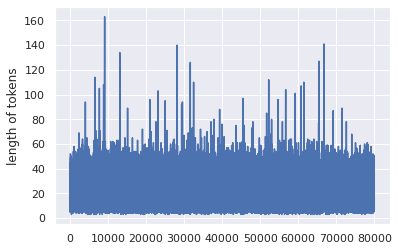

Maximum length is:  163


In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)
# when sample with first 40k and last 40k we got the maximum length is 230. And if we sampled with inbuilt function we got 126

In [20]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import get_linear_schedule_with_warmup

**BERT Classification**

In [22]:
from transformers import BertForSequenceClassification,AdamW


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

In [28]:
from transformers import get_linear_schedule_with_warmup
epochs = 2

In [29]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [30]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [31]:
from tqdm.notebook import tqdm
def train():
  torch.cuda.empty_cache()
  for epoch in tqdm(range(1, epochs+1)):
      
      model.train()
      
      loss_train_total = 0

      progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
      for batch in progress_bar:

          model.zero_grad()
          
          batch = tuple(b.to(device) for b in batch)
          
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                  }       

          outputs = model(**inputs)
          
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()
          training_loss = loss.item()/len(batch)
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(training_loss)})
          
          
      tqdm.write(f'\nEpoch {epoch}')
      
      loss_train_avg = loss_train_total/len(train_dataloader)            
      tqdm.write(f'Training loss: {loss_train_avg}')
      
      val_loss, predictions, true_vals = evaluate(val_dataloader)
      val_acc = accuracy(predictions, true_vals)
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'Accuracy: {val_acc}')

      return training_loss, val_loss, val_acc

In [33]:
trainingLoss = []
validationLoss =[]
testAcc = []

for i in range(1,11):
  train_sample = d_train.sample(n=(3472*i))
  X_train = train_sample.text
  y_train = train_sample.sentiment

  X_test = d_test.text
  y_test = d_test.sentiment

  X_val = d_val.text
  y_val = d_val.sentiment

  print('Tokenizing data...')
  train_inputs, train_masks = preprocessing_for_bert(X_train.to_numpy())
  val_inputs, val_masks = preprocessing_for_bert(X_val.to_numpy())
  test_inputs, test_masks = preprocessing_for_bert(X_test.to_numpy())

  train_labels = torch.tensor(y_train.to_numpy())
  val_labels = torch.tensor(y_val.to_numpy())
  test_labels = torch.tensor(y_test.to_numpy())

  batch_size = 32

  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

  val_data = TensorDataset(val_inputs, val_masks, val_labels)
  val_dataloader = DataLoader(val_data, shuffle = True, batch_size = batch_size)

  test_data = TensorDataset(test_inputs, test_masks, test_labels)
  test_dataloader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

  total_steps = len(train_dataloader)*epochs
  

  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_attentions = False, output_hidden_states = False)
  optimizer = AdamW(
    model.parameters(),
    lr=5e-5, # Initializing the learning Rate as suggested in the T5 official documentation
    eps=(1e-8),
  )
  scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  print(device)

  train_loss, val_loss, test_acc = train()
  trainingLoss.append(train_loss)
  validationLoss.append(val_loss)
  testAcc.append(test_acc)
print("trainingLoss")
print(trainingLoss)
print("validationLoss")
print(validationLoss)
print("TestAcc")
print(testAcc)
  

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceCla

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5232051723047134
Validation loss: 0.5200626439797251
Accuracy: 0.7567434210526316
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/217 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.47983914826597485
Validation loss: 0.42868535711577066
Accuracy: 0.8053618421052632
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/326 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.45982172166460134
Validation loss: 0.4030848435351723
Accuracy: 0.8196381578947368
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/434 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.4504947961063429
Validation loss: 0.39462627181881355
Accuracy: 0.8251644736842105
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/543 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.44233504758245595
Validation loss: 0.3988884183293895
Accuracy: 0.8197697368421053
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/651 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.4392310800731823
Validation loss: 0.38593725703264536
Accuracy: 0.8307565789473684
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/760 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.4363045707148941
Validation loss: 0.39518728264068304
Accuracy: 0.8220065789473684
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/868 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.423485824898366
Validation loss: 0.38383439200489144
Accuracy: 0.8308552631578947
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/977 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.41692839143464117
Validation loss: 0.4007416563049743
Accuracy: 0.8302960526315789
Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1085 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.4181531817270314
Validation loss: 0.4141775506891702
Accuracy: 0.8158552631578947
trainingLoss
[0.16369888186454773, 0.20808150370915732, 0.13587973515192667, 0.08039847016334534, 0.06873903671900432, 0.24018838008244833, 0.18671035766601562, 0.17618656158447266, 0.22977113723754883, 0.09232330322265625]
validationLoss
[0.5200626439797251, 0.42868535711577066, 0.4030848435351723, 0.39462627181881355, 0.3988884183293895, 0.38593725703264536, 0.39518728264068304, 0.38383439200489144, 0.4007416563049743, 0.4141775506891702]
validationAcc
[0.7567434210526316, 0.8053618421052632, 0.8196381578947368, 0.8251644736842105, 0.8197697368421053, 0.8307565789473684, 0.8220065789473684, 0.8308552631578947, 0.8302960526315789, 0.8158552631578947]


In [ ]:
test_loss, test_predictions, test_vals = evaluate(test_dataloader)
test_acc = accuracy(test_predictions, test_vals)

In [ ]:
test_acc

0.8378618421052632

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
test_preds = np.argmax(test_predictions,axis=1)
test_labels = test_vals
cm=confusion_matrix(test_labels, test_preds)
cm


array([[13013,  2203],
       [ 2726, 12458]])

In [ ]:
print(classification_report(test_labels, test_preds.round()))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     15216
           1       0.85      0.82      0.83     15184

    accuracy                           0.84     30400
   macro avg       0.84      0.84      0.84     30400
weighted avg       0.84      0.84      0.84     30400



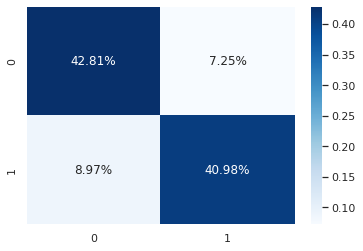

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')